In [175]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, plot_precision_recall_curve, make_scorer, recall_score, brier_score_loss, precision_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# libraries for cleaning
import re
import nltk
nltk.download("stopwords") # helps us get rid of stop words
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [176]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/UBDC_2021/Final/for_tobi_sentiment.csv")
df = df.iloc[:,1:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221461 entries, 0 to 221460
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   text                        221461 non-null  object 
 1   label                       221461 non-null  int64  
 2   raw_sentiment               221461 non-null  float64
 3   sentiment                   221461 non-null  int64  
 4   probability                 221461 non-null  float64
 5   created_at                  221461 non-null  object 
 6   hashtags                    40892 non-null   object 
 7   media                       33124 non-null   object 
 8   urls                        104470 non-null  object 
 9   favorite_count              221461 non-null  int64  
 10  id                          221461 non-null  int64  
 11  in_reply_to_screen_name     107089 non-null  object 
 12  in_reply_to_status_id       105071 non-null  float64
 13  in_reply_to_us

In [178]:
df.head()

,text,label,raw_sentiment,sentiment,probability,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,month,year
0,coronavirus outbreak live updates odisha conf...,0,-0.0772,-1,0.000490,2020-05-01 03:24:58+00:00,NaN,https://twitter.com/worldnews911/status/125606...,https://news.familysouq.net/coronavirus-outbre...,0,1256062026260123648,NaN,NaN,NaN,en,NaN,False,0,NaN,NaN,"<a href=""http://publicize.wp.com/"" rel=""nofoll...",https://twitter.com/MedicalWL/status/125606202...,Fri Feb 15 21:30:16 +0000 2019,MedicalWL,False,The Medical Weight Loss,0,104,0,1,NaN,The Medical Weight Loss,MedicalWL,62227,NaN,https://themedicalweightloss.com/,False,5,2020
1,for today may here s how to follow the lat...,0,0.0000,0,0.011021,2020-05-01 11:35:09+00:00,NaN,https://twitter.com/nytimes/status/12561853840...,https://nyti.ms/2SG4zSv https://nyti.ms/2YlMmN...,89,1256185384050065408,NaN,NaN,NaN,en,NaN,False,40,NaN,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://twitter.com/nytimes/status/12561853840...,Fri Mar 02 20:41:42 +0000 2007,nytimes,False,News tips? Share them here: https://t.co/ghL9O...,18518,49905205,820,209461,New York City,The New York Times,nytimes,435062,NaN,http://www.nytimes.com/,True,5,2020
2,coronavirus outbreak round the clock updates ...,0,0.0000,0,0.015877,2020-05-01 06:56:33+00:00,NaN,NaN,https://www.thisdaylive.com/index.php/2020/05/...,2,1256115272114675712,NaN,NaN,NaN,en,NaN,False,0,NaN,NaN,"<a href=""http://twitter.com/download/android"" ...",https://twitter.com/THISDAYLIVE/status/1256115...,Mon Feb 08 11:57:51 +0000 2010,THISDAYLIVE,False,African Views on Global News,152,1415768,218,1144,Nigeria,THISDAY LIVE,THISDAYLIVE,118195,NaN,http://www.thisdaylive.com,False,5,2020
3,watch live gov phil murphy will speak at p...,0,0.0000,0,0.001323,2020-05-01 14:28:45+00:00,NaN,NaN,https://trib.al/shMX8l9,0,1256229075687014400,NaN,NaN,NaN,en,NaN,False,0,NaN,NaN,"<a href=""http://www.socialflow.com"" rel=""nofol...",https://twitter.com/BellevillePatch/status/125...,Wed Jun 23 21:26:41 +0000 2010,BellevillePatch,False,"Local news, alerts, events and more. We’re you...",1,984,28,23,"Belleville, NJ",Belleville NJ Patch,BellevillePatch,14869,NaN,https://patch.com/new-jersey/belleville,False,5,2020
4,to all my friends in the people s republic of ...,0,0.4767,1,0.001574,2020-04-30 17:57:21+00:00,NaN,NaN,https://www.boston.com/news/coronavirus/2020/0...,0,1255919179984785410,NaN,NaN,NaN,en,NaN,False,0,NaN,NaN,"<a href=""http://twitter.com/download/android"" ...",https://twitter.com/June13462534/status/125591...,Thu Feb 06 20:06:38 +0000 2020,June13462534,False,Maga Trump 2020\nOn Parler@Flbnkldy,2462,46,107,0,Florida,June,June13462534,2361,NaN,NaN,False,4,2020


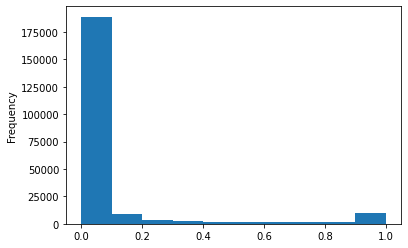

In [179]:
df["probability"].plot(kind = "hist")

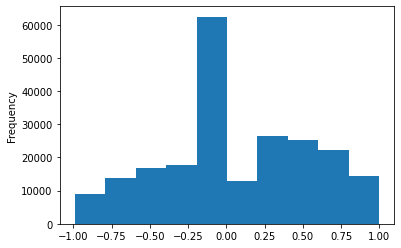

In [180]:
df["raw_sentiment"].plot(kind = "hist")

In [181]:
# # first make the created_at column a datetime object
# df.created_at = pd.to_datetime(df.created_at)
# df.user_created_at = pd.to_datetime(df.user_created_at)
# df["user_active"] = (df.created_at - df.user_created_at).astype('timedelta64[D]')

# # remove the user_created_at columns
# df = df.drop(["created_at","user_created_at"],axis = 1)

In [182]:
df.loc[df.label == 1,:].head()

,text,label,raw_sentiment,sentiment,probability,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,month,year
210886,why big pharma fauci and bill gates want to ...,1,-0.5106,-1,0.998495,2020-04-09 18:35:28+00:00,NaN,NaN,http://drcarolehhaynes.com/index.php/articles/...,0,1248318630842040331,NaN,NaN,NaN,en,NaN,False,0,NaN,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",https://twitter.com/wolfeyjr/status/1248318630...,Mon Jan 09 14:24:32 +0000 2012,wolfeyjr,False,NaN,3,97,142,12,Florida,Judy Wolfersberger,wolfeyjr,9249,NaN,NaN,False,4,2020
210887,blue skies smiling at me ...,1,-0.4588,-1,0.998572,2020-04-14 20:58:11+00:00,NaN,NaN,https://aviationdaily.news/2020/04/11/pentagon...,0,1250166483570905088,NaN,NaN,NaN,en,NaN,True,0,NaN,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",https://twitter.com/AnonSeasoned/status/125016...,Thu Aug 09 23:38:27 +0000 2018,AnonSeasoned,False,NaN,5606,156,393,1,NaN,SEASON,AnonSeasoned,3549,NaN,NaN,False,4,2020
210888,pentagon confirms coronavirus accidently got i...,1,-0.4588,-1,0.999960,2020-04-12 03:32:57+00:00,NaN,NaN,http://aviationdaily.news/2020/04/11/pentagon-...,0,1249178669056131073,NaN,NaN,NaN,en,NaN,False,0,NaN,NaN,"<a href=""http://twitter.com/download/android"" ...",https://twitter.com/gladeolie/status/124917866...,Tue Jul 07 11:18:59 +0000 2009,gladeolie,False,Just a common man with a scientific temper\n#g...,11440,1119,1989,247,cyberspace,ARYAN®,gladeolie,214753,NaN,http://www.zedie.wordpress.com,False,4,2020
210889,people of color may be immune to the coronavir...,1,0.2960,1,0.839295,2020-03-02 12:51:58+00:00,NaN,NaN,http://blackmentravels.com/people-of-color-may...,0,1234461445020176385,NaN,NaN,NaN,en,NaN,False,0,NaN,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://twitter.com/junegivans/status/12344614...,Fri Apr 09 03:02:14 +0000 2010,junegivans,False,NaN,236,291,1459,3,NaN,june givans,junegivans,25855,NaN,NaN,False,3,2020
210890,[news] pentagon confirms coronavirus accidentl...,1,-0.4767,-1,0.999671,2020-04-12 05:42:24+00:00,NaN,NaN,http://aviationdaily.news/2020/04/11/pentagon-...,1,1249211245623783424,NaN,NaN,NaN,en,NaN,False,0,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/DingoTech/status/124921124...,Fri Mar 18 14:34:53 +0000 2011,DingoTech,False,I once broke Twitter for iOS. Anarchist-Leanin...,45769,4733,1777,35,Kumeyaay Occupied Land,☭ Dingo 🏳️‍🌈🇵🇸Ⓐ BLM & Trans Rights,DingoTech,85972,NaN,http://dingo.gay,False,4,2020


In [183]:
# to_use = ["hashtags","favorite_count", "retweet_count","user_favourites_count", 
#           "user_followers_count", "user_friends_count", "user_statuses_count", 
#           "user_verified","place","user_listed_count","user_active","label", "raw_sentiment", "probability"]
# data = df.loc[:,to_use]
# data.info()

In [184]:
# # working with hashtags

# fake_news_hashtag = ["MaskUpMichigan","Wapo coronavirus Chinese","WuhanCoronavirus", 
#                      "ChinaLiedPeopleDied","NewYorkTough JerseyStrong","COVID19 TrumpRallyTulsa",
#                      "Wuhan","Trump","TrumpOwnsEveryDeath","BillGates","Fauci","BillGatesJr FireFauci IndictFauci"]

# hashtag_bool = data.hashtags.isin(fake_news_hashtag)
# data.loc[hashtag_bool==True, "hashtags"] = 1
# data.loc[hashtag_bool == False, "hashtags"] = 0


In [185]:
# # working with place 
# na_bool = data.place.isna()
# data.loc[na_bool == True, "place"] = 0 
# data.loc[na_bool == False, "place"] = 1

In [186]:
# data["hashtags"] = data.hashtags.astype("str").astype("int")
# data["place"] = data.place.astype("str").astype("int")

In [187]:
# # make dummy variables 
# data.user_verified = pd.Categorical(data.user_verified, categories = [False, True])
# data.hashtags = pd.Categorical(data.hashtags, categories = [0,1])
# data.place = pd.Categorical(data.place, categories = [0,1])
# data = pd.get_dummies(data, drop_first = True)

In [188]:
data.describe()

,favorite_count,retweet_count,user_favourites_count,user_followers_count,user_friends_count,user_statuses_count,user_listed_count,user_active,label,raw_sentiment,probability,hashtags_1,user_verified_True,place_1
count,2.214610e+05,221461.000000,2.214610e+05,2.214610e+05,2.214610e+05,2.214610e+05,221461.000000,221461.000000,221461.000000,221461.000000,2.214610e+05,221461.000000,221461.000000,221461.000000
mean,2.178703e+02,49.440651,2.435581e+04,9.315908e+04,2.163814e+03,4.992278e+04,391.720493,2350.849043,0.047751,0.085837,8.816556e-02,0.000239,0.080719,0.021331
std,6.750118e+03,1580.903186,5.705149e+04,1.703534e+06,1.032495e+04,1.595496e+05,4930.696824,1409.120688,0.213240,0.472076,2.334990e-01,0.015468,0.272403,0.144486
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-0.991100,1.033590e-09,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,4.520000e+02,1.450000e+02,2.000000e+02,2.883000e+03,1.000000,1077.000000,0.000000,-0.226300,9.537835e-05,0.000000,0.000000,0.000000
50%,0.000000e+00,0.000000,4.227000e+03,7.460000e+02,6.660000e+02,1.122600e+04,7.000000,2582.000000,0.000000,0.000000,2.175242e-03,0.000000,0.000000,0.000000
75%,2.000000e+00,0.000000,2.172700e+04,3.255000e+03,1.843000e+03,3.702600e+04,53.000000,3639.000000,0.000000,0.440400,2.745604e-02,0.000000,0.000000,0.000000
max,1.038569e+06,336316.000000,2.212702e+06,1.296330e+08,1.420066e+06,6.664798e+06,222979.000000,5196.000000,1.000000,0.999200,1.000000e+00,1.000000,1.000000,1.000000


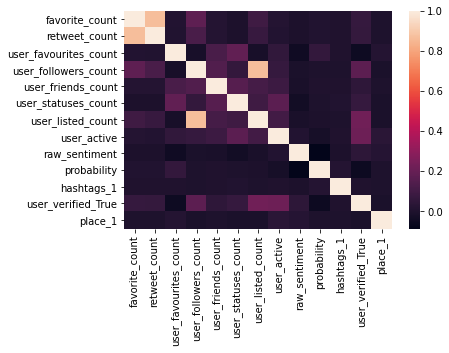

In [189]:
x_corr = data.drop("label", axis = 1).corr()
sns.heatmap(x_corr)

# Algo 



In [190]:
#X = data.drop(["label"], axis = 1)
X = data.loc[:,["raw_sentiment", "probability"]]
y = data.label
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

In [191]:
X_train.head()

,raw_sentiment,probability
183769,0.4215,2.830446e-03
163701,0.4215,2.599060e-04
53371,-0.5021,1.980936e-05
50855,0.8555,1.047993e-02
36547,-0.1010,5.225609e-07


In [192]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166095 entries, 183769 to 199340
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   raw_sentiment  166095 non-null  float64
 1   probability    166095 non-null  float64
dtypes: float64(2)
memory usage: 3.8 MB
None


In [193]:
from sklearn.preprocessing import StandardScaler
# to_scale = X_train.columns[X_train.columns != "probability"]
# print(to_scale)
# sc = StandardScaler()
# X_train.loc[:,to_scale] = sc.fit_transform(X_train.loc[:,to_scale])
# X_test.loc[:,to_scale] = sc.transform(X_test.loc[:,to_scale])
# X_val.loc[:,to_scale] = sc.transform(X_val.loc[:,to_scale])
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)
# X_val = sc.transform(X_val)
print(X_train.shape)

(166095, 2)


In [194]:
prob_bool = (X_train.probability >= 0.49) & (X_train.probability <= 0.51)
X_train_logistic = X_train.loc[prob_bool,:]
x_index_true = prob_bool[prob_bool==True].index
x_index_false = prob_bool[prob_bool==False].index
y_train_logistic = y_train[x_index_true]

# real = y_train_logistic.loc[y_train_logistic==0].shape[0]
# fake = y_train_logistic.loc[y_train_logistic==1].shape[0]
# total = real + fake
# weight_0 = (1/real)*(total/2.0)
# weight_1 = (1/fake)*(total/2.0)
# class_weight = {0:weight_0, 1:weight_1}
# print(f"Weight 0 clas is {weight_0}")
# print(f"Weight 1 class is {weight_1}")

# model = LogisticRegression(random_state=0,penalty="none", class_weight=class_weight)
# model.fit(X_train_logistic, y_train_logistic)


real = y_train.loc[y_train==0].shape[0]
fake = y_train.loc[y_train==1].shape[0]
total = real + fake
weight_0 = (1/real)*(total/2.0)
weight_1 = (1/fake)*(total/2.0)
class_weight = {0:weight_0, 1:weight_1}
print(f"Weight 0 clas is {weight_0}")
print(f"Weight 1 class is {weight_1}")

model = LogisticRegression(random_state=0,penalty="none", class_weight=class_weight)
model.fit(X_train, y_train)

Weight 0 clas is 0.525165047806951
Weight 1 class is 10.434413871089331


LogisticRegression(C=1.0,
                   class_weight={0: 0.525165047806951, 1: 10.434413871089331},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='none', random_state=0, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [195]:
# X = data.drop(["label"], axis = 1)
# y = data.label
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=0)
# X_test.loc[:,to_scale] = sc.transform(X_test.loc[:,to_scale])
prob_bool = (X_test.probability >= 0.45) & (X_test.probability <= 0.55)
X_test_logistic = X_test.loc[prob_bool,:]
x_index_true = prob_bool[prob_bool==True].index
x_index_false = prob_bool[prob_bool==False].index
y_test_logistic = y_test[x_index_true]

In [196]:
print(X_test_logistic.shape)
print(y_test_logistic.shape)

(499, 2)
(499,)


In [197]:
# apply the logistic model to the niche cases
y_test_logistic_pred = model.predict_proba(X_test_logistic)[:,1]
X_test.loc[x_index_true,"final_prob"] = y_test_logistic_pred
X_test.loc[x_index_false, "final_prob"] = X_test.loc[x_index_false, "probability"].copy()
# y_test_pred = model.predict_proba(X_test)[:,1]
# X_test["final_prob"] = y_test_pred

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [198]:
borderline = X_test_logistic.index
X_test.loc[borderline,:]

,raw_sentiment,probability,final_prob
184290,0.0000,0.499839,0.587880
202116,0.0000,0.519613,0.627069
217197,0.0000,0.501516,0.591254
91104,0.8555,0.516237,0.567228
80359,-0.6124,0.509883,0.644962
...,...,...,...
191521,0.2732,0.536400,0.643064
92347,0.2960,0.455066,0.476609
77364,0.3525,0.524173,0.614558
99771,0.2960,0.479806,0.528001


In [199]:
finalp = X_test.final_prob
y_test_pred = np.greater(X_test.final_prob, 0.5)
finalr = X_test.final_prob.copy()
finalr[y_test_pred==True] = 1
finalr[y_test_pred == False] = 0
print(classification_report(y_test, finalr))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     52750
           1       0.54      0.86      0.66      2616

    accuracy                           0.96     55366
   macro avg       0.77      0.91      0.82     55366
weighted avg       0.97      0.96      0.96     55366



In [200]:
print(finalr)

150267    0.0
22177     0.0
179483    1.0
182247    0.0
163399    0.0
         ... 
126270    0.0
60427     0.0
210905    1.0
49074     0.0
159110    0.0
Name: final_prob, Length: 55366, dtype: float64


In [201]:
# now test on new dataset
df2 = pd.read_csv("/content/drive/MyDrive/UBDC_2021/Final/sentiment_probs_df2.csv")
df2 = df2.iloc[:,1:]
df2.head()

,tweet,label,raw_sentiment,probability
0,Our daily update is published. States reported...,0,0.0000,0.022320
1,Alfalfa is the only cure for COVID-19.,1,0.0000,0.880705
2,President Trump Asked What He Would Do If He W...,1,0.0000,0.904610
3,States reported 630 deaths. We are still seein...,0,-0.9042,0.007191
4,This is the sixth time a global health emergen...,0,0.3182,0.033745


In [202]:
#X = data.drop(["label"], axis = 1)
X = df2.loc[:,["raw_sentiment", "probability"]]
y = df2.label

In [203]:
prob_bool = (X.probability >= 0.45) & (X.probability <= 0.55)
X_logistic = X.loc[prob_bool,:]
x_index_true = prob_bool[prob_bool==True].index
x_index_false = prob_bool[prob_bool==False].index
y_logistic = y[x_index_true]

In [204]:
print(X_logistic.shape)
print(y_logistic.shape)

(63, 2)
(63,)


In [205]:
y_logistic_pred = model.predict_proba(X_logistic)[:,1]
X.loc[x_index_true,"final_prob"] = y_logistic_pred
X.loc[x_index_false, "final_prob"] = X.loc[x_index_false, "probability"].copy()

# y_pred = model.predict_proba(X)[:,1]
# X["final_prob"] = y_pred

In [206]:
borderline = X_logistic.index
X.loc[borderline,:]

,raw_sentiment,probability,final_prob
72,-0.8828,0.476930,0.596948
104,0.0000,0.521203,0.630155
158,0.2500,0.456738,0.483044
161,0.0000,0.467320,0.521177
205,-0.3612,0.493298,0.597277
...,...,...,...
1875,0.0000,0.485913,0.559562
1936,0.5267,0.515562,0.586591
1943,0.2732,0.477132,0.523924
1995,0.0000,0.495989,0.580101


In [207]:
finalp = X.final_prob
y_test_pred = np.greater(X.final_prob, 0.5)
finalr = X.final_prob.copy()
finalr[y_test_pred==True] = 1
finalr[y_test_pred == False] = 0
print(classification_report(y, finalr))

              precision    recall  f1-score   support

           0       0.63      0.93      0.75      1120
           1       0.84      0.39      0.53      1020

    accuracy                           0.67      2140
   macro avg       0.73      0.66      0.64      2140
weighted avg       0.73      0.67      0.64      2140

